# San Francisco Parking Exploratory Data Analysis
this notebook is for the in depth analyis of the San Francisco Parking Ticket data. The main goal of this will be to answer four questions. 

1. Can we identify streets that are less likely for enforcement officer to travel through, when looking for residential overtime tickets?

2. How long can we expect to park before we have to move our car?

3. Which hour of street cleaning is most effective at getting people ticketed?

4. Does less frequent street cleaning get mroe tickets per sweep?




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import datetime as dt
import time
from scipy import stats
import geopandas as gpd
import folium
import sqlite3
import math
import seaborn as sns
import statsmodels.formula as sm
import scipy 
%matplotlib inline

/home/colin/.local/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
def result_query(querystring):
    resultdf = pd.read_sql(sql= querystring, con = conn)
    
    return resultdf

In [3]:
raw_folder = '/home/colin/Desktop/SF_Parking/data/raw/'
proc_folder = '/home/colin/Desktop/SF_Parking/data/processed/'

In [4]:
conn = sqlite3.connect(raw_folder + 'SF_Parking.db')
c = conn.cursor()
tables = result_query("SELECT name FROM sqlite_master where type = 'table'")
tables

,name
0,raw_ticket_data
1,raw_address_data
2,single_address
3,ticket_data
4,street_sweep_data
5,address_data
6,street_volume_data


# Theory
Let's test our initial hypothesis, but include street parking availability now. 

In [5]:
#Lets categorize addresses by our street volume 
streets = result_query("Select distinct t3.lineid, t3.streetname, nhood, distance, total_ea, vvol_carea, vvol_trkea, vvol_busea, speed_ea, oneway, count(*) total_tickets, park_supply "
                       'from ticket_data t1 join address_data t2 on t1.address = t2.address ' 
                       ' join street_volume_data t3 on t2.lineid = t3.lineid '
                       " Where ViolationDesc = 'RES/OT'  group by t3.lineid")
c.execute('Select Max(TickIssueDate), Min(TickIssueDate) from ticket_data')
totaldays = c.fetchone()
maxdate = time.strptime( totaldays[0], '%Y-%m-%d %H:%M:%S')
mindate = time.strptime( totaldays[1], '%Y-%m-%d %H:%M:%S')
totaldays = (time.mktime(maxdate) - time.mktime(mindate)) / (60*60*24)
totalyears = totaldays / 365

In [6]:
totalyears

2.1698249619482497

Let's create a few new columns and fill in some bad records. First Let's fix the parking supply column. If anyone got a residential overtime spot, there was clearly some parking available. Let's use the neighborhood average spots per mile to fill this in where its null or 0. 

In [7]:
streets['parkpermile'] = streets['park_supply'] / streets['distance']
streets_mean = streets[streets.park_supply > 0 ].groupby(by = ['nhood'], as_index = False)['parkpermile'].mean()
streets_1 = streets[streets.park_supply > 0 ]
streets_2 = streets[(streets.park_supply== 0) | (pd.isnull(streets.park_supply)) ]
streets_2 = streets_2.merge(streets_mean, left_on = 'nhood', right_on = 'nhood')

In [8]:
print(streets_1.shape)
print(streets_2.shape)

(686, 13)
(3140, 14)


In [9]:
streets_2['park_supply'] = streets_2['parkpermile_y'] * streets_2['distance']
streets_2.rename(columns = {'parkpermile_y':'parkpermile'}, inplace = True)
streets_2.drop(columns =['parkpermile_x'], inplace = True)
streets = streets_1.append(streets_2)

In [10]:
#to avoid any problems log transforming, we'll add 1 to all street volume
streets['total_ea'] = streets['total_ea'] + 1

/home/colin/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 0, 'Total Tickets')

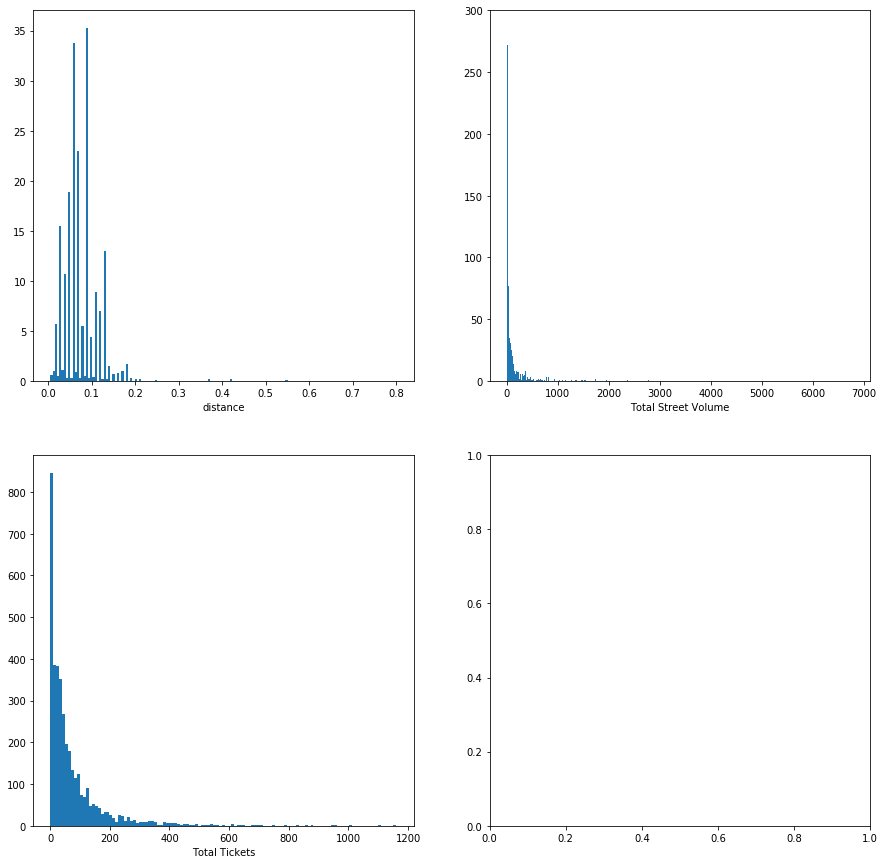

In [11]:
import matplotlib.pyplot as plt 
fig, axplots = plt.subplots(2,2, figsize = (15, 15))

axplots[0,0].hist(streets.distance, bins = 'auto', normed = True)
axplots[0,0].set_xlabel('distance')

axplots[0,1].hist(streets.total_ea, bins = 'auto')
axplots[0,1].set_xlabel('Total Street Volume')
axplots[0,1].set_ylim(0,300)

axplots[1,0].hist(streets.total_tickets, bins = 'auto' )
axplots[1,0].set_xlabel('Total Tickets')

/home/colin/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/colin/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


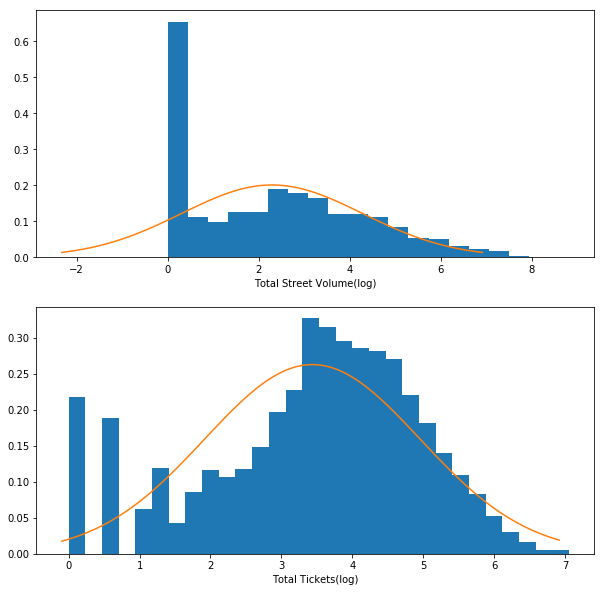

In [12]:
#Lets Log Transform a few to see if they appear a little more normal
from scipy.stats import norm

fig, axplots = plt.subplots(2, figsize = (10, 10))
log_volume = np.log(streets['total_ea'])
log_tickets = np.log(streets['total_tickets'])
vol_mean = log_volume.mean()
tick_mean = log_tickets.mean()
vol_std = log_volume.std()
tick_std = log_tickets.std()
vol_normals = norm(loc = vol_mean, scale = vol_std)
vol = np.linspace(vol_normals.ppf(0.01), 
                        vol_normals.ppf(0.99), 100)

tick_normals = norm(loc = tick_mean, scale = tick_std)
ticks = np.linspace(tick_normals.ppf(0.01), 
                        vol_normals.ppf(0.99), 
                        100)


axplots[0].hist(log_volume, bins = 'auto', normed = True )
axplots[0].set_xlabel('Total Street Volume(log)')
axplots[0].plot(vol, vol_normals.pdf(vol))

axplots[1].hist(np.log(streets.total_tickets), bins = 'auto', normed = True )
axplots[1].set_xlabel('Total Tickets(log)')
axplots[1].plot(ticks, tick_normals.pdf(ticks))

/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Cumulative Distribution of Street Volume')

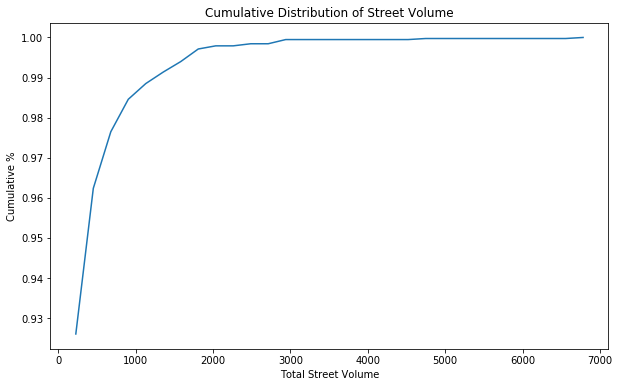

In [13]:
#Lets look at the percentiles of streetvolume
plt.figure(figsize = (10,6))
counts, bin_edges = np.histogram(streets['total_ea'], bins=30, normed=True)
cdf = np.cumsum (counts)
plt.plot(bin_edges[1:], cdf/cdf[-1])
plt.xlabel('Total Street Volume')
plt.ylabel('Cumulative %')
plt.title('Cumulative Distribution of Street Volume')




In [14]:
for q in [25, 50, 75, 100]:
    print ("{}%% percentile: {}".format (q, np.percentile(streets['total_ea'], q)))

25%% percentile: 1.144835
50%% percentile: 9.716535
75%% percentile: 41.4122025
100%% percentile: 6780.86341


Text(0.5, 1.0, 'Scatter Plot of Street Volume vs. Total Tickets')

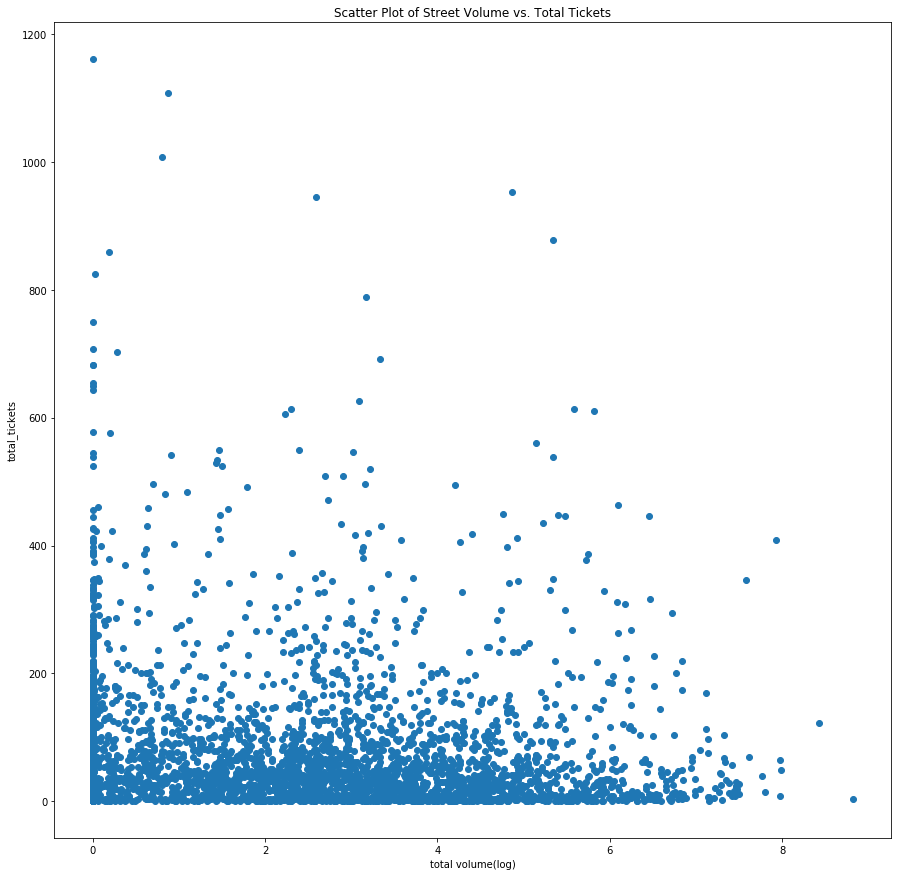

In [15]:
# Lets scatter volume against total tickets

plt.figure(figsize = (15, 15))
plt.scatter(x = np.log(streets['total_ea']), y = streets['total_tickets'])
plt.xlabel('total volume(log)')
plt.ylabel('total_tickets')
plt.title('Scatter Plot of Street Volume vs. Total Tickets')

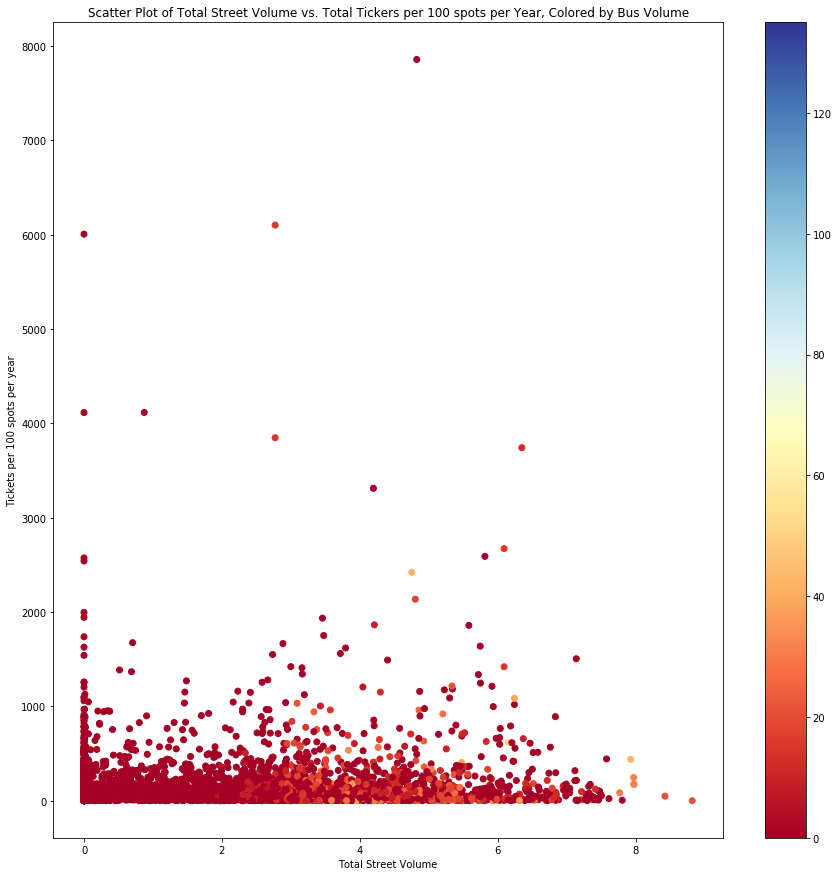

In [16]:
# Lets do the same, but create a new measure, tickets per 100 parking spaces 
streets['tickperspot'] = streets['total_tickets'] / (streets['park_supply'] / 100) / totalyears
plt.figure(figsize = (15, 15))
plt.scatter(x = np.log(streets['total_ea']), y = streets['tickperspot'], cmap = 'RdYlBu', c = streets['vvol_busea'])
plt.title('Scatter Plot of Total Street Volume vs. Total Tickers per 100 spots per Year, Colored by Bus Volume')
plt.ylabel('Tickets per 100 spots per year')
plt.xlabel('Total Street Volume')
plt.colorbar()

Only the higher volume streets get any bus volume, and they all seem to be lower tickets per spot. 

Text(0, 0.5, 'Frequency')

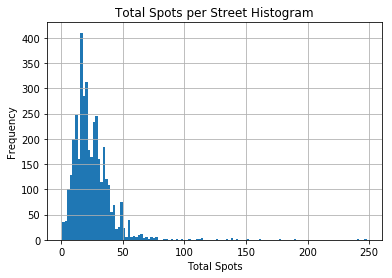

In [17]:
#Histogram of spots per street
streets['park_supply'].hist(bins = 'auto')
plt.title('Total Spots per Street Histogram')
plt.xlabel('Total Spots')
plt.ylabel('Frequency')

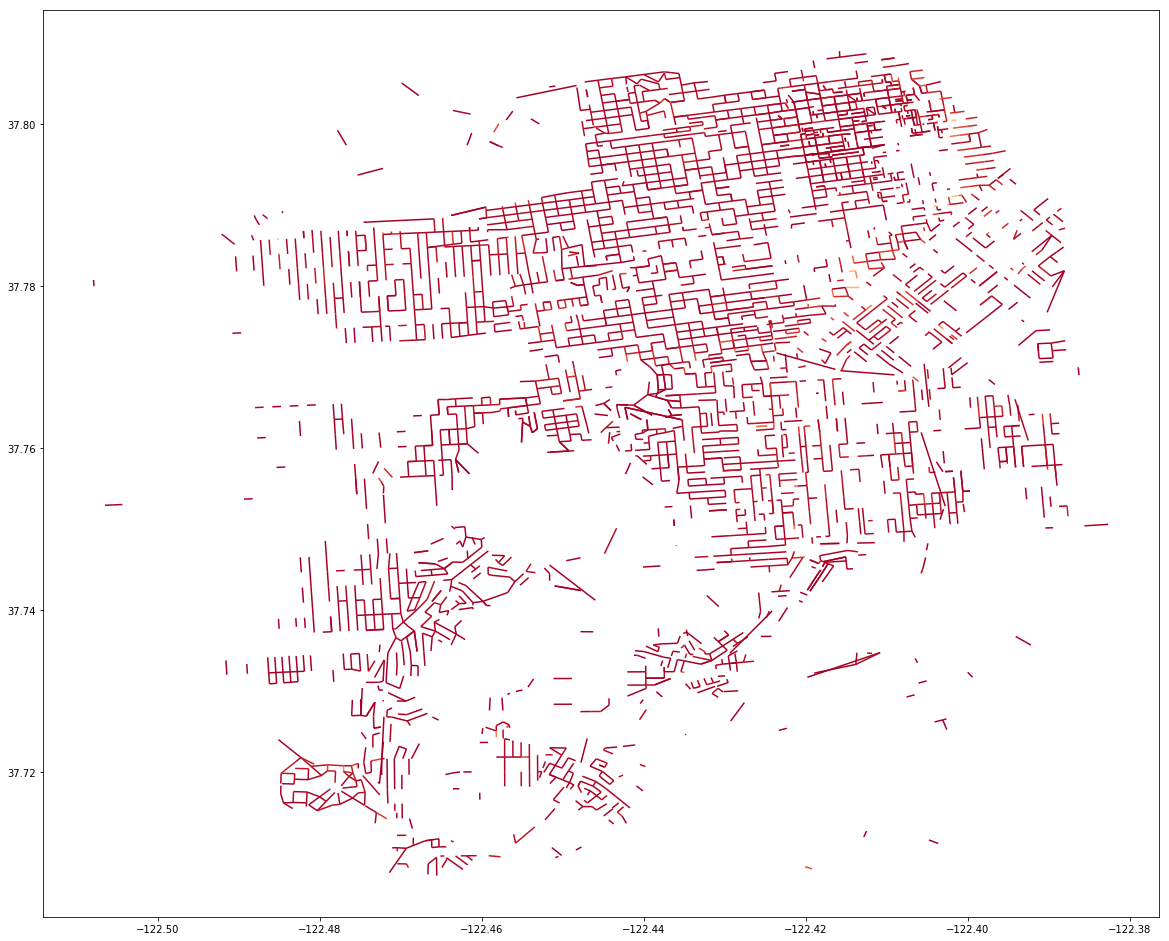

In [18]:
#Let's map all of the streets we've identified 
streetvolume = gpd.read_file(proc_folder + './final_streets/SF_Street_Data.shp')

streetvolume = streetvolume.to_crs(epsg = 4326)
times = ['am', 'pm', 'ev', 'ea']
for time in times:
    streetvolume['totalinv_' + time]  = streetvolume['total_'+time].apply(lambda x: np.log(1/(x+.5)))
    
df = streetvolume.merge(streets, left_on = 'lineid', right_on = 'lineid')
    
df.plot(figsize = (20,20), cmap = 'RdYlGn', column = 'tickperspot')

In [19]:
streets['total_tickets'].sum()

282660

In [20]:
#Lets split into two populations based on their street volume, we will then create a weighted total average of tickets per 100 spots
df_lowvol = streets[streets.total_ea <=  np.percentile(streets['total_ea'], 50)]
df_highvol = streets[streets.total_ea > np.percentile(streets['total_ea'], 50)]

In [21]:
df_lowvol['weight'] = df_lowvol['park_supply'] / df_lowvol['park_supply'].sum()
(df_lowvol['weight'] * df_lowvol['tickperspot']).sum()

/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


144.12889183516415

In [22]:
df_highvol['weight'] = df_highvol['park_supply'] / df_highvol['park_supply'].sum()
(df_highvol['weight'] * df_highvol['tickperspot']).sum()

/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


131.20945506612395

They are extremely similar, and highger street volume appears to correlate with mroe tickets. 

In [23]:
#Let's split into smaller groups
df_1 = streets[streets.total_ea <=  np.percentile(streets['total_ea'], 25)]
df_2 = streets[(streets.total_ea <= np.percentile(streets['total_ea'], 50)) & (streets.total_ea >  np.percentile(streets['total_ea'], 25))]
df_3 = streets[(streets.total_ea <= np.percentile(streets['total_ea'], 75)) & (streets.total_ea >  np.percentile(streets['total_ea'], 50))]
df_4 = streets[streets.total_ea > np.percentile(streets['total_ea'], 75)]

df_1.describe()

,lineid,distance,total_ea,vvol_carea,vvol_trkea,vvol_busea,speed_ea,oneway,total_tickets,park_supply,parkpermile,tickperspot
count,957.000000,957.000000,957.000000,957.000000,957.000000,957.0,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000
mean,44644.013584,0.079180,1.005860,0.004760,0.001100,0.0,15.508420,0.068966,81.743992,25.447009,328.919458,179.423421
std,6928.250429,0.046518,0.020613,0.018502,0.005353,0.0,5.756122,0.253528,113.712385,16.193184,118.705537,338.599037
min,29078.000000,0.010000,1.000000,0.000000,0.000000,0.0,11.111110,0.000000,1.000000,2.000000,41.666667,0.404269
25%,39694.000000,0.050000,1.000000,0.000000,0.000000,0.0,13.888890,0.000000,14.000000,14.919048,281.045372,31.532983
50%,44410.000000,0.070000,1.000000,0.000000,0.000000,0.0,16.666670,0.000000,40.000000,22.267196,317.462625,90.732466
75%,50407.000000,0.110000,1.000000,0.000000,0.000000,0.0,16.666670,0.000000,104.000000,33.433951,359.458874,206.302063
max,57759.000000,0.800300,1.144690,0.144240,0.074380,0.0,99.000010,1.000000,1160.000000,240.090000,1883.116883,6006.628904


In [24]:
df_4.describe()

,lineid,distance,total_ea,vvol_carea,vvol_trkea,vvol_busea,speed_ea,oneway,total_tickets,park_supply,parkpermile,tickperspot
count,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000
mean,43522.570533,0.076542,275.892374,251.463765,15.102423,8.326186,16.468206,0.292581,62.172414,24.160764,323.448593,175.044705
std,5514.792184,0.060786,456.587048,434.997701,25.978186,13.136574,3.759805,0.455186,93.640730,20.342857,212.017501,405.336894
min,28122.000000,0.004820,41.414330,2.558040,0.062440,0.000000,8.866510,0.000000,1.000000,1.172143,50.000000,0.643566
25%,40454.000000,0.050000,68.049440,57.386240,2.213810,0.000000,13.888780,0.000000,10.000000,14.000000,261.257078,20.906327
50%,43911.000000,0.060000,116.915550,103.172930,6.049420,0.000000,16.665740,0.000000,31.000000,19.399093,311.111111,71.761514
75%,47007.000000,0.090000,277.024190,251.716600,16.630140,15.000000,18.639620,1.000000,71.000000,28.629252,343.471178,172.635105
max,57756.000000,0.690000,6780.863410,6344.826690,413.856720,135.000000,54.999940,1.000000,952.000000,248.026623,6181.818182,7857.776687


In this case, it may be wise to use the central limit theorem, because you will not have the availablility of streets at your fingertips when finding a parking spot. Let's do what we did in the first notebook, but on our new data. 

In [25]:
#since so many have the same value, we should probably filter the group on a sorted index so the sample sizes are all the same 
streets.sort_values(by = 'total_ea', inplace = True)
streets.reset_index(inplace = True)

Text(0.5, 0, 'Tickets per 100 spots per year')

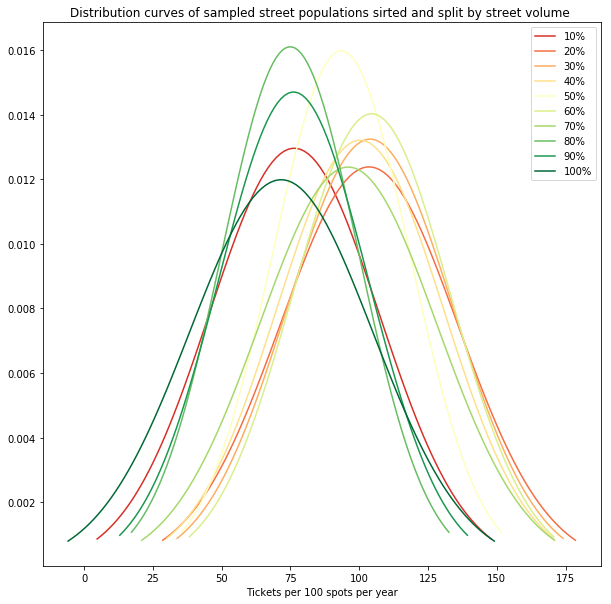

In [26]:

plt.figure(figsize = (10, 10))
means = {}
stds = {}
for i in np.arange(1,11):
    if i == 1:
        df = streets[streets.index <=  np.percentile(streets.index, i*10)]
    else:
        df = streets[(streets.index <=  np.percentile(streets.index, i*10)) & (streets.index >  np.percentile(streets.index, (i-1)*10))]
               
    sample = []
    for j in np.arange(1,1000):
        sample.append(df['tickperspot'].sample(n = 20).median())
        
    sample = np.array(sample)
        
    means[i] = sample.mean()
    stds[i] = sample.std()
    normals = norm(loc = means[i], scale = stds[i])
    
    x = np.linspace(normals.ppf(0.01), 
                        normals.ppf(0.99), 
                        100)
    labelstr = str(i * 10) + '%'
    plt.plot(x, normals.pdf(x), label = labelstr, color =  plt.cm.RdYlGn(i/10))
plt.legend( loc = 0)
plt.title('Distribution curves of sampled street populations sirted and split by street volume ')
plt.xlabel('Tickets per 100 spots per year')

Once again, it looks like our lower volume streets get less tickets. 

Text(0.5, 0, 'Tickets per 100 spots per year')

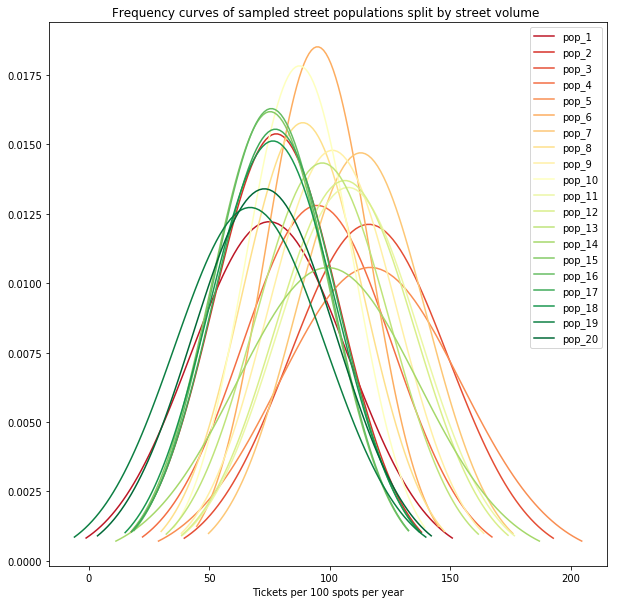

In [27]:
plt.figure(figsize = (10, 10))
means = {}
stds = {}

for i in np.arange(1,21):
    if i == 1:
        df = streets[streets.index <=  np.percentile(streets.index, i*5)]
    else:
        df = streets[(streets.index <=  np.percentile(streets.index, i*5)) & (streets.index >  np.percentile(streets.index, (i-1)*5))]
              
    sample = []
    for j in np.arange(1,1000):
        sample.append(df['tickperspot'].sample(n = 20).median())
        
    sample = np.array(sample)
        
    means[i] = sample.mean()
    stds[i] = sample.std()
    normals = norm(loc = means[i], scale = stds[i])
    
    x = np.linspace(normals.ppf(0.01), 
                        normals.ppf(0.99), 
                        100)
    labelstr = 'pop_' + str(i)
    plt.plot(x, normals.pdf(x), label = labelstr, color =  plt.cm.RdYlGn(i/20))
plt.legend( loc = 0)
plt.title('Frequency curves of sampled street populations split by street volume ')
plt.xlabel('Tickets per 100 spots per year')

# Factor Analysis

Let's see if we can create another model using our new information. 

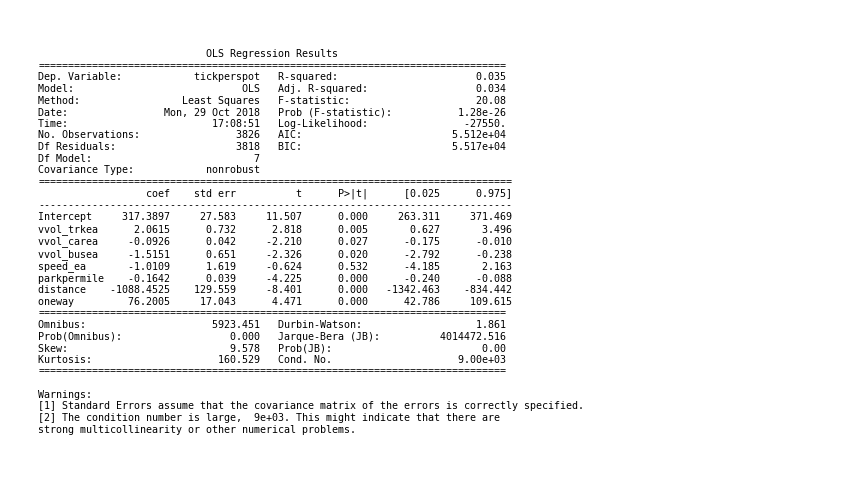

In [28]:
import statsmodels.api as sm
columns = ['vvol_trkea', 'vvol_carea', 'vvol_busea', 'speed_ea', 'parkpermile', 'distance', 'oneway']

model = sm.OLS.from_formula('tickperspot ~ '+ '+'.join(columns) , streets)
res = model.fit()
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace') 
plt.axis('off')
plt.tight_layout()
plt.show()

Once again, car volume wasn't very statistically significant. 

In [29]:
streets['fitted'] =  res.fittedvalues
streets.sort_values(by = 'fitted', inplace = True)

Text(0.5, 0, 'Tickets per 100 spots per year')

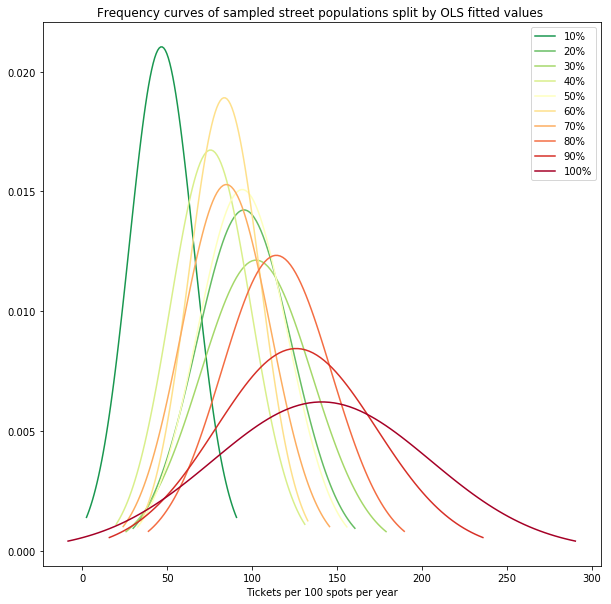

In [30]:
plt.figure(figsize = (10, 10))
means = {}
stds = {}
totalsize = streets.shape[0]
for i in np.arange(1,11):
    if i == 1:
        df = streets[0:int(totalsize * .1)]
    else:
        df = streets[((i-1)/10 * totalsize).astype(int): (((i)/10) * totalsize).astype(int)]
        
    sample = []
    for j in np.arange(1,1000):
        sample.append(df['tickperspot'].sample(n = 20).median())
        
    sample = np.array(sample)
        
    means[i] = sample.mean()
    stds[i] = sample.std()
    normals = norm(loc = means[i], scale = stds[i])
    
    x = np.linspace(normals.ppf(0.01), 
                        normals.ppf(0.99), 
                        100)
    labelstr = str(i * 10) + '%'
    plt.plot(x, normals.pdf(x), label = labelstr, color =  plt.cm.RdYlGn(1-(i/10)))
plt.legend( loc = 0)
plt.title('Frequency curves of sampled street populations split by OLS fitted values ')
plt.xlabel('Tickets per 100 spots per year')

Compared to the original model, this one fits much better when using it to decide streets to park at. Our r^2 is also slightly higher, although still not very high. There is a large amount of variability, and a very large sample size. 

The Higher our variables get, the fit seems to be stronger, which would confirm that using these measures may be an accurate way to estimate ticket probability. Let's check out some diagnostic plots to confirm this. 

In [31]:
model_fit = res
# fitted 
model_fitted_y = model_fit.fittedvalues

# residuals
model_residuals = model_fit.resid

# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag


Text(0, 0.5, 'Standardized Residuals')

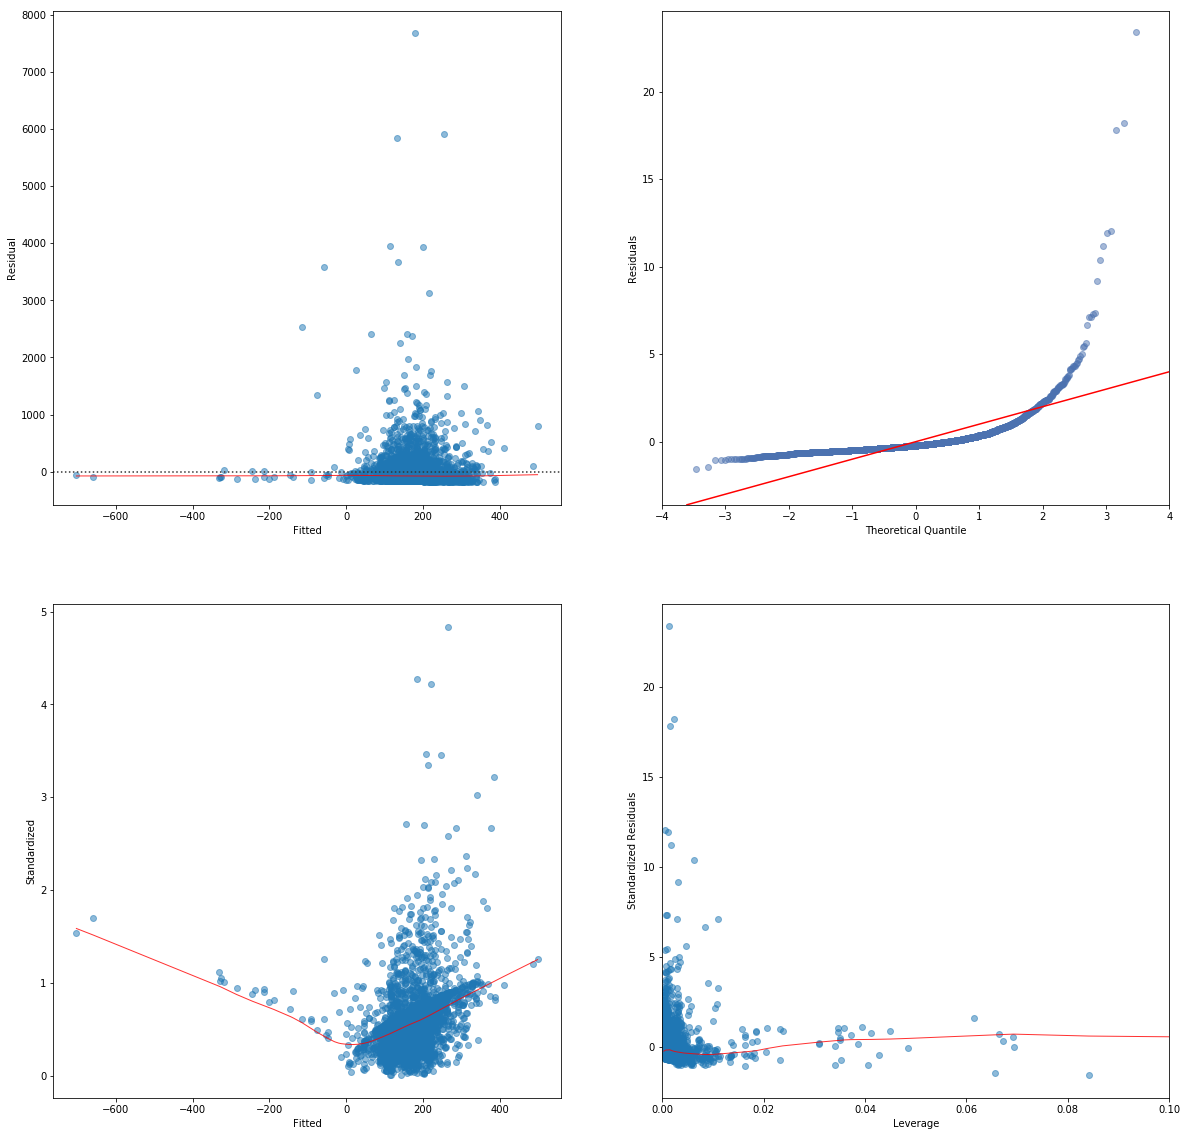

In [32]:
from statsmodels.graphics.gofplots import ProbPlot
#All four diagnostic plots in one place
fig, axarr = plt.subplots(2,2, figsize = (20,20))
QQ = ProbPlot(model_norm_residuals)

#residuals 
sns.residplot( model_fitted_y, 'tickperspot', data=streets, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axarr[0,0])
axarr[0,0].set_xlabel('Fitted')
axarr[0,0].set_ylabel('Residual')


#Q-Q
QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1, ax = axarr[0,1])
axarr[0,1].set_xlabel('Theoretical Quantile')
axarr[0,1].set_ylabel('Residuals')
axarr[0,1].set_xlim(-4,4)



#scale - location
axarr[1,0].scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axarr[1,0])
axarr[1,0].set_xlabel('Fitted')
axarr[1,0].set_ylabel('Standardized')


#Leverage
axarr[1,1].scatter(model_leverage, model_norm_residuals, alpha=0.5)
sns.regplot(model_leverage, model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axarr[1,1])
axarr[1,1].set_xlim(0,0.1)
axarr[1,1].set_xlabel('Leverage')
axarr[1,1].set_ylabel('Standardized Residuals')

The Q-Q Plot indicates there may be a non-linear relationship here. Let's try a few other fits. 

In [33]:
df = streets
for column in columns:
    df[column] = df[column] + 0.01
    
formstring = 'tickperspot ~np.log(vvol_trkea)+np.log(vvol_carea)+np.log(vvol_busea)+np.log(speed_ea) + np.log(parkpermile) + oneway'
model = sm.OLS.from_formula(formstring , streets)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            tickperspot   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     24.19
Date:                Mon, 29 Oct 2018   Prob (F-statistic):           2.92e-28
Time:                        17:09:00   Log-Likelihood:                -27548.
No. Observations:                3826   AIC:                         5.511e+04
Df Residuals:                    3819   BIC:                         5.515e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1635.2700    149.715     10.923      0.000    1341.741    1928.799
np.log(vvol_trkea)     22.4916      5.063      4.443      0.000      12.566      32.418
np.log(vvol_carea)    -15.1912      3.551     -4.278      0.000     -22.153      -8.230
np.log(vvol_busea)     -4.1348      1.922     -2.151      0.032      -7.904      -0.366
np.log(speed_ea)     -212.8548     34.823     -6.113      0.000    -281.128    -144.582
np.log(parkpermile)  -148.9648     17.944     -8.302      0.000    -184.145    -113.784
oneway                 54.7877     16.905      3.241      0.001      21.645      87.931
==============================================================================
Omnibus:                     5906.698   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3929925.051
Skew:                           9.530   Prob(JB):                         0.00
Kurtosis:                     158.848   Cond. No.                         220.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Standardized Residuals')

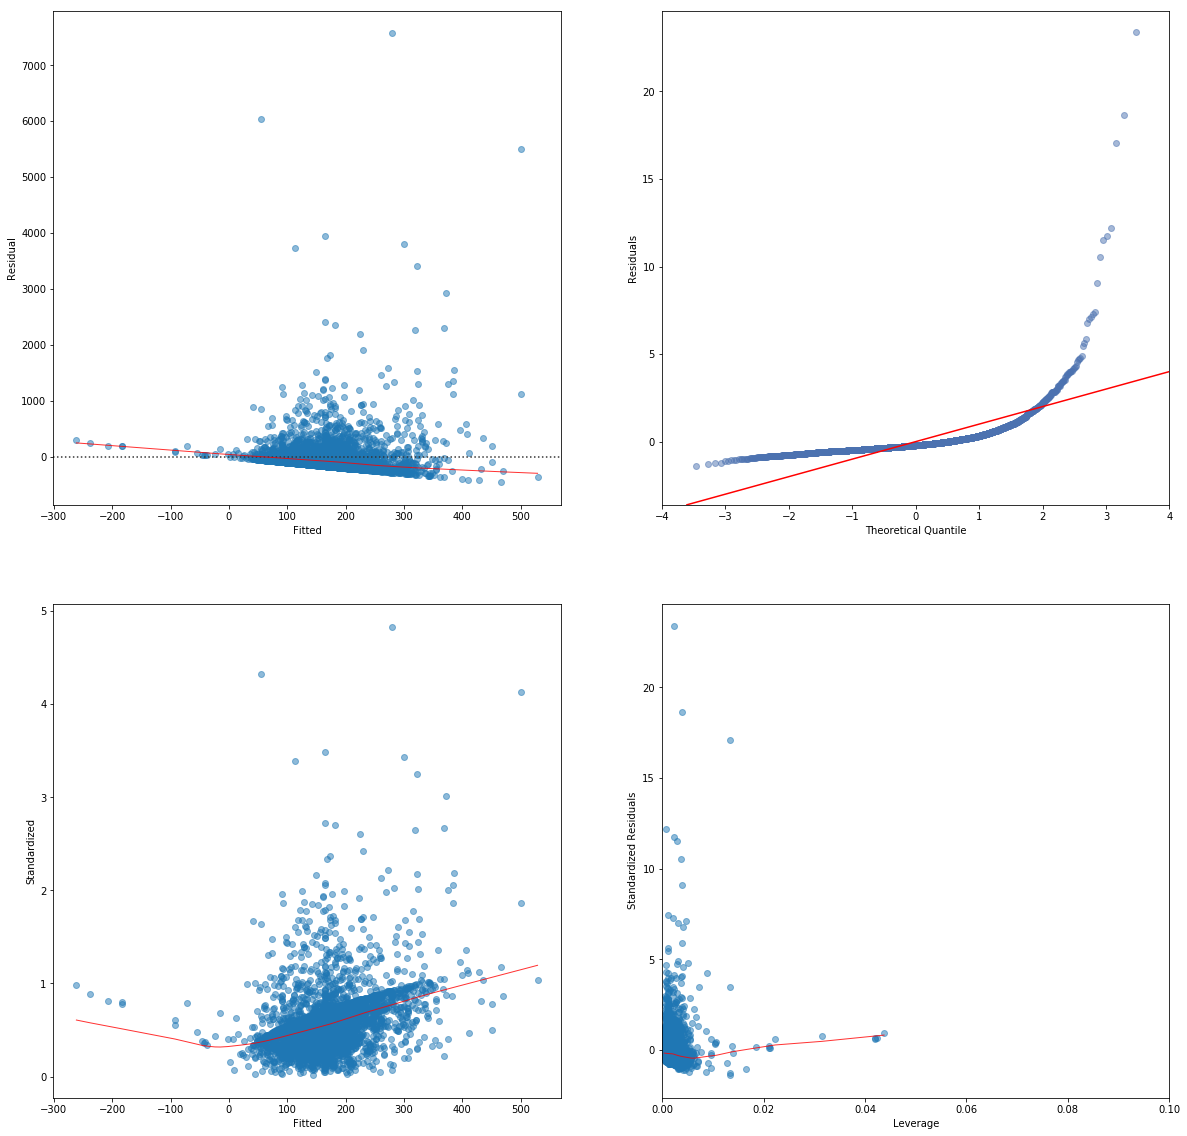

In [34]:
# Log fit seems to be a little better. 
model_fit = res
# fitted 
model_fitted_y = model_fit.fittedvalues

# residuals
model_residuals = model_fit.resid

# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
from statsmodels.graphics.gofplots import ProbPlot
#All four diagnostic plots in one place
fig, axarr = plt.subplots(2,2, figsize = (20,20))
QQ = ProbPlot(model_norm_residuals)

#residuals 
sns.residplot( model_fitted_y, 'tickperspot', data=streets, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axarr[0,0])
axarr[0,0].set_xlabel('Fitted')
axarr[0,0].set_ylabel('Residual')


#Q-Q
QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1, ax = axarr[0,1])
axarr[0,1].set_xlabel('Theoretical Quantile')
axarr[0,1].set_ylabel('Residuals')
axarr[0,1].set_xlim(-4,4)



#scale - location
axarr[1,0].scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axarr[1,0])
axarr[1,0].set_xlabel('Fitted')
axarr[1,0].set_ylabel('Standardized')


#Leverage
axarr[1,1].scatter(model_leverage, model_norm_residuals, alpha=0.5)
sns.regplot(model_leverage, model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axarr[1,1])
axarr[1,1].set_xlim(0,0.1)
axarr[1,1].set_xlabel('Leverage')
axarr[1,1].set_ylabel('Standardized Residuals')

Text(0, 0.5, 'Frequency')

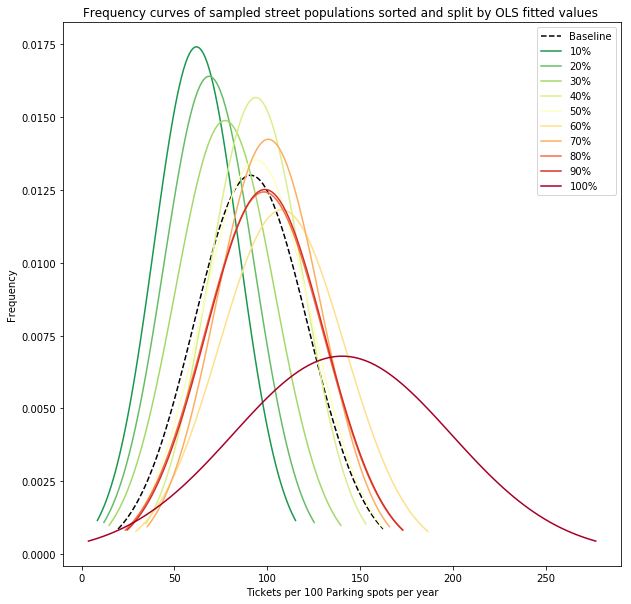

In [35]:
#Re-do our central limit exercise once again. 
streets['fitted'] =  res.fittedvalues
streets.sort_values(by = 'fitted', inplace = True)
plt.figure(figsize = (10, 10))
means = {}
stds = {}
df = streets
sample = []
boxdata = []
#create baseline curve
for j in np.arange(1,1000):
    sample.append(df['tickperspot'].sample(n = 20).median())
 

sample = np.array(sample)

means['base'] = sample.mean()
stds['base'] = sample.std()
normals = norm(loc = means['base'], scale = stds['base'])

x = np.linspace(normals.ppf(0.01), 
                    normals.ppf(0.99), 
                    100)
labelstr = str(i * 10) + '%'
plt.plot(x, normals.pdf(x), label = 'Baseline', color = 'black', linestyle = '--')

        
for i in np.arange(1,11):
    if i == 1:
        df = streets[0:int(totalsize * .1)]
    else:
        df = streets[((i-1)/10 * totalsize).astype(int): (((i)/10) * totalsize).astype(int)]
        
    sample = []
    boxdata.append(df['tickperspot'])
    for j in np.arange(1,1000):
        sample.append(df['tickperspot'].sample(n = 20).median())
        
    sample = np.array(sample)
        
    means[i] = sample.mean()
    stds[i] = sample.std()
    normals = norm(loc = means[i], scale = stds[i])
    
    x = np.linspace(normals.ppf(0.01), 
                        normals.ppf(0.99), 
                        100)
    labelstr = str(i * 10) + '%'
    plt.plot(x, normals.pdf(x), label = labelstr, color =  plt.cm.RdYlGn(1-(i/10)))
plt.legend( loc = 0)
plt.title('Frequency curves of sampled street populations sorted and split by OLS fitted values ')
plt.xlabel('Tickets per 100 Parking spots per year')
plt.ylabel('Frequency')

''

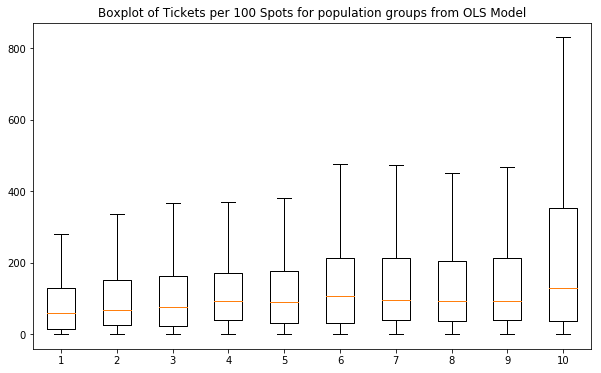

In [36]:
plt.figure(figsize = (10,6))
plt.boxplot(boxdata, showfliers = False)
plt.title('Boxplot of Tickets per 100 Spots for population groups from OLS Model')
;


Let's try to include some interactions, we'll look through all combinations of unbias predictors and add them to a model. 

In [37]:
columnlist = ['vvol_carea', 'vvol_trkea', 'vvol_busea', 'speed_ea', 'parkpermile', 'distance', 'oneway']
formulastring = 'tickperspot ~ '

formulastring += '+'.join(columns) 

for combo in itertools.combinations(columnlist, 2):
    formulastring += '+' + combo[0] + '*' + combo[1]


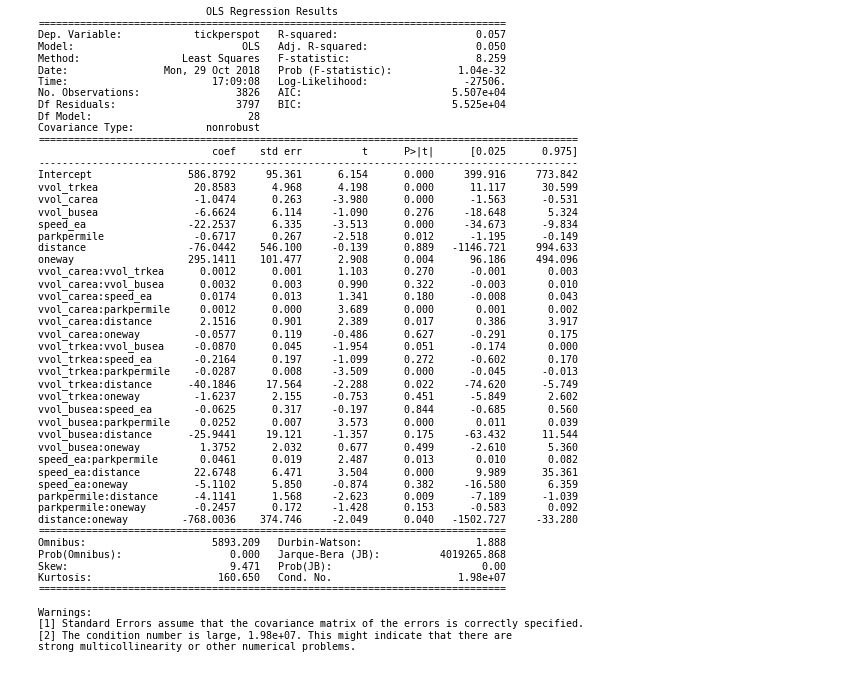

In [38]:
model = sm.OLS.from_formula(formulastring , streets)
res = model.fit()
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace') 
plt.axis('off')
plt.tight_layout()
plt.show()

The main interaction that has both a significant weight and p-value is parkpermile* distance, which gives our density a third dimension. We'll include that in our final model, along with the logarithmic predictors.  

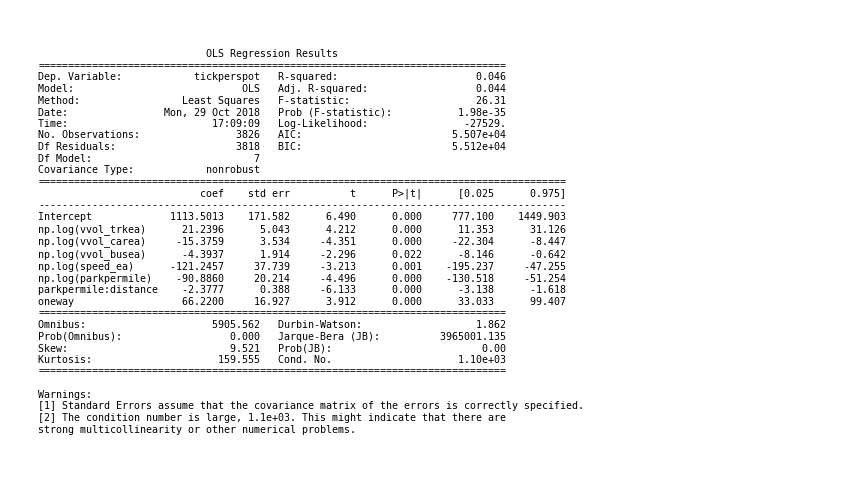

In [39]:
formstring = 'tickperspot ~np.log(vvol_trkea)+np.log(vvol_carea)+np.log(vvol_busea)+np.log(speed_ea) + np.log(parkpermile)'\
        ' + parkpermile:distance + oneway'
model = sm.OLS.from_formula(formstring , streets)
res = model.fit()
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace') 
plt.axis('off')
plt.tight_layout()
plt.show()


<function ndarray.mean>

Text(0, 0.5, 'Frequency')

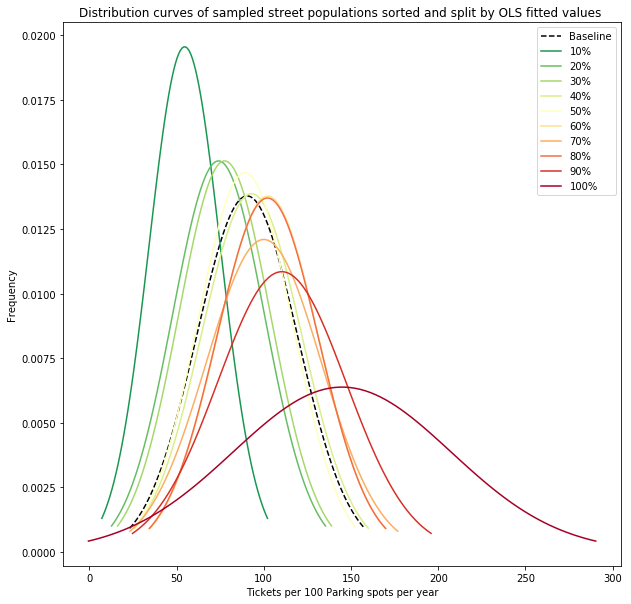

In [42]:
#Re-do our central limit exercise once again. We'll save some confidence intervals for later. 
streets['fitted'] =  res.fittedvalues
streets.sort_values(by = 'fitted', inplace = True)
plt.figure(figsize = (10, 10))
means = {}
stds = {}
lci = {}
uci = {}
df = streets
sample = []
boxdata = []
#create baseline curve
for j in np.arange(1,1000):
    sample.append(df['tickperspot'].sample(n = 20).median())
 


sample = np.array(sample)

means['base'] = sample.mean()
stds['base'] = sample.std()
normals = norm(loc = means['base'], scale = stds['base'])

x = np.linspace(normals.ppf(0.01), normals.ppf(0.99), 100)
labelstr = str(i * 10) + '%'
plt.plot(x, normals.pdf(x), label = 'Baseline', color = 'black', linestyle = '--')

        
for i in np.arange(1,11):
    if i == 1:
        df = streets[streets.fitted <=  np.percentile(streets.fitted, i*10)]
    else:
        df = streets[(streets.fitted <=  np.percentile(streets.fitted, i*10)) & (streets.fitted >  np.percentile(streets.fitted, (i-1)*10))]
               
    sample = []
    boxdata.append(df['tickperspot'])
    for j in np.arange(1,1000):
        sample.append(df['tickperspot'].sample(n = 20).median())
        
    sample = np.array(sample)
        
    means[i]= sample.mean()
    stds[i] = sample.std()
    normals = norm(loc = means[i], scale = stds[i])
    
    x = np.linspace(normals.ppf(0.01), normals.ppf(0.99), 100)
    labelstr = str(i * 10) + '%'
    plt.plot(x, normals.pdf(x), label = labelstr, color =  plt.cm.RdYlGn(1-(i/10)))
plt.legend( loc = 0)
plt.title('Distribution curves of sampled street populations sorted and split by OLS fitted values ')
plt.xlabel('Tickets per 100 Parking spots per year')
plt.ylabel('Frequency')

In [43]:
means[1] / means['base']

0.6039548952199043

In [44]:
means[1] / means[10]

0.3770122976626965

In [45]:
df_worst = streets[streets.fitted >  np.percentile(streets.fitted, (90))]
df_best = streets[streets.fitted <  np.percentile(streets.fitted, (10))]

In [46]:
df_worst.describe()

,index,lineid,distance,total_ea,vvol_carea,vvol_trkea,vvol_busea,speed_ea,oneway,total_tickets,park_supply,parkpermile,tickperspot,fitted
count,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000
mean,1515.117493,43587.198433,0.069187,157.348615,139.321945,13.164424,3.892245,14.219284,0.675796,82.433420,13.673362,245.718947,363.101131,293.959974
std,920.770156,5354.699617,0.031679,273.175032,255.855709,21.315991,8.325570,2.246454,0.472328,116.106447,7.744150,94.958114,715.939650,37.112913
min,8.000000,29599.000000,0.015300,1.000000,0.010000,0.010000,0.010000,8.876510,0.010000,1.000000,1.000000,33.343333,1.689387,252.216421
25%,1082.500000,40366.500000,0.040000,1.010795,0.010000,0.013725,0.010000,13.800105,0.010000,8.000000,8.562931,200.010000,37.859336,265.364340
50%,1186.000000,41936.000000,0.070000,33.977090,24.302390,1.787930,0.010000,13.898890,1.010000,34.000000,12.230428,227.344267,133.651334,285.349751
75%,1733.500000,46447.000000,0.080000,188.082320,155.687000,19.267100,4.510000,16.659300,1.010000,108.500000,19.043084,322.926667,369.550303,311.728723
max,3826.000000,57756.000000,0.200000,1805.561640,1742.086540,159.593680,60.190000,25.000220,1.010000,702.000000,38.646825,681.919346,7857.776687,450.348806


In [47]:
df_best.describe()

,index,lineid,distance,total_ea,vvol_carea,vvol_trkea,vvol_busea,speed_ea,oneway,total_tickets,park_supply,parkpermile,tickperspot,fitted
count,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.00000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000
mean,1505.299213,43824.677165,0.138069,107.139120,95.827881,4.406619,5.934619,17.96482,0.054619,86.107612,50.517593,446.894912,86.179760,42.515929
std,871.592438,6427.984332,0.090694,488.825012,459.996922,28.101665,10.063718,9.68654,0.206738,120.614289,28.193287,339.111612,113.781257,71.624472
min,6.000000,29231.000000,0.015500,1.000000,0.010000,0.010000,0.010000,11.12111,0.010000,1.000000,4.281465,235.814899,0.404269,-546.164871
25%,878.000000,38118.000000,0.100000,2.872340,1.196150,0.019980,0.010000,13.89889,0.010000,12.000000,36.927020,331.726847,13.900718,31.838944
50%,1311.000000,44640.000000,0.120000,11.995540,5.478600,0.085150,0.010000,16.67667,0.010000,50.000000,44.444767,430.325451,52.127473,64.704587
75%,2324.000000,48481.000000,0.140000,42.565360,28.881440,0.819340,12.010000,16.67667,0.010000,107.000000,55.941009,523.086923,109.400439,79.037516
max,3810.000000,57726.000000,0.810300,6780.863410,6344.836690,413.866720,69.010000,99.01001,1.010000,1007.000000,248.026623,6181.828182,828.737026,92.157985


# Conclusion
The difference between the means of the most desired streets and the baseline are double in this model. This model was also better at identifying which streets would be the worst to park at. 

# Question
How long can I actually park at a residential overtime area, and hope I don't get a ticket?

This one is much more theoretical and more just for a little challening fun, as we would need a lot more data to fully answer it with concrete numbers. We would need more information on travel paths of the officers, and potentially some data on the cars that were parked. However, we can try and take a stab at it using some high level numbers. 

First, lets clarify the assumptions and process for estimating this probaility. There are two parts we must solve in this question. The first part is the probability that they come down the street you are parked in. This probability will increase with time. The second includes the probability they come back, and in what time frame. 

Part 1. We'll assume the same success rate of each street, as in every X parking spots he passes on any street, they'll get one. But how do we arrive at this? We'll need some very high level estimates. First, we'll estimate the total number of spots they pass. 


We'll assume he travels roughly 75% of the weighted average freeflow speed(while he is looking for offenders), as from visual estimates. We'll also assume their full day is about 75% utilized over 6 hours a day.We'll also take time out for writing tickets, ~ 2 minutes each. 




In [48]:
streetdata = result_query('Select lineid, distance, park_supply, speed_ea from street_volume_data')

ticket_data = result_query("Select * from ticket_data where ViolationDesc = 'RES/OT' ")

address_data = result_query('Select address, lineid from address_data')

df = ticket_data.merge(address_data, left_on = 'address', right_on = 'address')
df = df.merge(streetdata, left_on = 'lineid', right_on = 'lineid')

c.execute("Select Count(distinct lineid) from ticket_data t1 join address_data t2 on t1.address = t2.address")
totalticks = c.fetchone()[0]
c.execute("Select Count(distinct lineid) from ticket_data t1 join address_data t2 on t1.address = t2.address where violationdesc = 'RES/OT'")
resticks = c.fetchone()[0]

percent_res = resticks/totalticks

In [49]:
#find the average of non street cleaning per day 
df['TickDate']= df['TickIssueDate'].apply(lambda x: pd.to_datetime(x).date())
tix_by_officer = df.groupby(by = ['TickDate','TickBadgeIssued'], as_index = False)['TicketNumber'].size().reset_index(name='counts')

In [50]:
#Let's see how many officers per day are patrolling
officer_by_day = tix_by_officer.groupby(by = ['TickDate'], as_index = False).size().reset_index(name='counts')
avg_officers = officer_by_day['counts'].mean()
avg_officers

22.603719599427755

In [51]:
avg_tix = tix_by_officer['counts'].mean()
avg_tix

17.899050632911393

Roughly 22 officers and 18 tickets

In [52]:

average_freeflow_speed = df['speed_ea'].mean() * .75

validstreet = streetdata[streetdata.park_supply > 0 ]

average_spots_per_mile = validstreet['park_supply'] / validstreet['distance']
average_spots_per_mile = average_spots_per_mile.mean()
print(average_spots_per_mile)                            
total_spots_per_day = average_freeflow_speed * (6-avg_tix*2/60) * percent_res * average_spots_per_mile 
total_spots_per_day

336.5361945212397


8397.485342166658

Now we need to find total residential parking spots

In [53]:
#Now well take the average number of spots per street and multiply it by the total number of streets

mean_parking_spots = df['park_supply'].mean()

total_spots = mean_parking_spots * df['lineid'].nunique()
total_spots

16582.9025653719

In [54]:
total_spots_checked = total_spots_per_day * avg_officers

In [55]:
total_spots_checked

189814.40401463976

In [56]:
#Arrival rate in miuntes
average_checks = total_spots_checked / total_spots

print(average_checks)
arrival_rate = 10*60 / average_checks
print(arrival_rate)

11.446392045443634
52.41826399252477


So you can expect that each spot, on average, will be checked roughly 3.54 times a day.  Most residential permit areas are restricted from 8AM to 8PM, so 12 hours total, but take out 2 because you can't get a ticket after parking past the 10th hour. We'll use an exponential distribution  to plot the probability of seeing an officer in X time units. 

(0, 400)

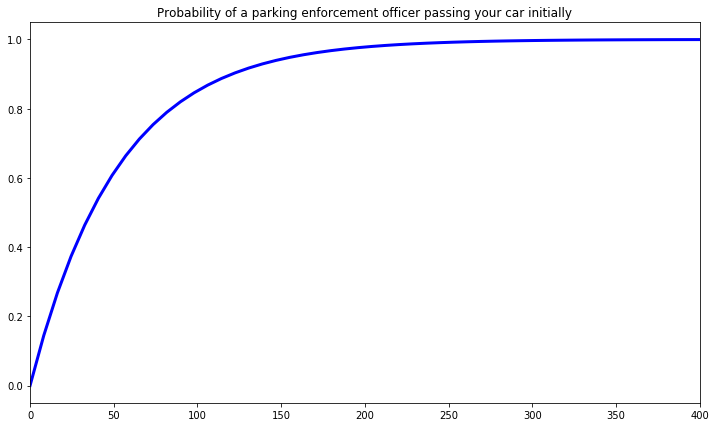

In [57]:
from scipy.stats import expon
x = np.linspace(0,400)
ax = plt.figure()
prob = stats.expon.cdf(x=x, scale= arrival_rate)
plt.plot(x, prob, color = "blue", linewidth = 3)
plt.title("Probability of a parking enforcement officer passing your car initially")
plt.xlim(0,400)

Part 2. 
On each ticket, they write down what time they first came and marked your car, and then what time they wrote the ticket. This implies they have a list of which cars they marked and where, and attempt to go check on them. Unfortunately, the initial time checked and the time returned were not included in the data. We will have to look for special circumstances under which we can find a distribution. We will look for circumstances where a ticketing officer wrote two tickets on the same street, but not within roughly 2 and 4 hours  of each other. this is under the assumption he marked the first car after he wrote the second. 

In [58]:
df['TickDate'] = df['TickIssueDate'].apply(lambda x:  dt.datetime.strftime(pd.to_datetime(x),'%Y-%m-%d'))

In [59]:
df = df[['TickBadgeIssued', 'TickIssueDate', 'TicketNumber', 'TickIssueTime', 'lineid', 'TickDate']]

In [60]:
df = df.merge(df, left_on = ['TickDate', 'lineid', 'TickBadgeIssued'], right_on = ['TickDate', 'lineid', 'TickBadgeIssued'])

In [61]:
def delta_minutes(x,y):
    timedelta = y-x
    
    return timedelta.seconds / 60
    

In [62]:
df= df[(df.TicketNumber_x != df.TicketNumber_y) & (df.TickIssueTime_y > df.TickIssueTime_x)]
df['delta'] = df.apply(lambda x: delta_minutes(pd.to_datetime(x['TickIssueDate_x']), pd.to_datetime(x['TickIssueDate_y'])), axis = 1)

In [63]:
df

,TickBadgeIssued,TickIssueDate_x,TicketNumber_x,TickIssueTime_x,lineid,TickDate,TickIssueDate_y,TicketNumber_y,TickIssueTime_y,delta
1,000022,2016-07-11 11:31:00,870006561,11:31,48940.0,2016-07-11,2016-07-11 11:36:00,870006605,11:36,5.0
2,000022,2016-07-11 11:31:00,870006561,11:31,48940.0,2016-07-11,2016-07-11 11:32:00,870006572,11:32,1.0
3,000022,2016-07-11 11:31:00,870006561,11:31,48940.0,2016-07-11,2016-07-11 11:34:00,870006583,11:34,3.0
9,000022,2016-07-11 11:32:00,870006572,11:32,48940.0,2016-07-11,2016-07-11 11:36:00,870006605,11:36,4.0
11,000022,2016-07-11 11:32:00,870006572,11:32,48940.0,2016-07-11,2016-07-11 11:34:00,870006583,11:34,2.0
13,000022,2016-07-11 11:34:00,870006583,11:34,48940.0,2016-07-11,2016-07-11 11:36:00,870006605,11:36,2.0
25,000194,2016-08-01 12:53:00,871494245,12:53,48940.0,2016-08-01,2016-08-01 13:05:00,871494260,13:05,12.0
26,000194,2016-08-01 11:53:00,871494120,11:53,48940.0,2016-08-01,2016-08-01 12:53:00,871494245,12:53,60.0
29,000194,2016-08-01 11:53:00,871494120,11:53,48940.0,2016-08-01,2016-08-01 12:34:00,871494212,12:34,41.0
30,000194,2016-08-01 11:53:00,871494120,11:53,48940.0,2016-08-01,2016-08-01 12:28:00,871494201,12:28,35.0


In [64]:
#Only include that between 1 and 4 hours
df = df[(df.delta > 60) & (df.delta < 240)]

Text(0, 0.5, 'Frequency')

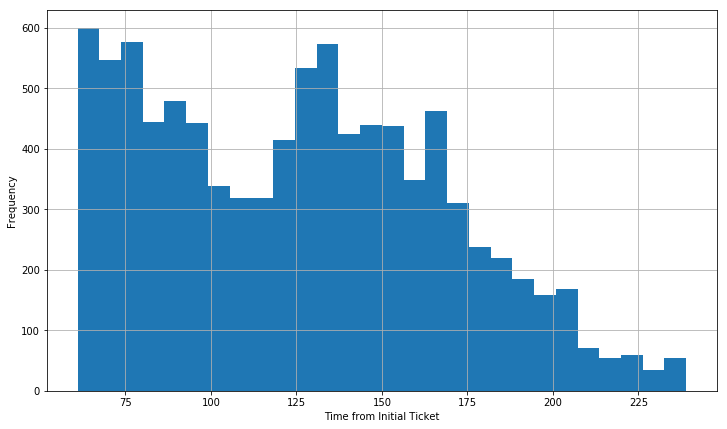

In [65]:
#This will be the ditribution of the 'return rate'
df['delta'].hist(bins = 'auto')
plt.xlabel('Time from Initial Ticket')
plt.ylabel('Frequency')

This is interesting and something I would expect. It also implies for many of these streets that they will come intermediatey to check anyway, and it is most liekly a standard route. We only really care about the distribution after 120 minutes, when he can give you a ticket. We'll also filter on less than 3 hours, beuase the distribution tails off there, and I would expect if might be because they passed through multiple times. 

Text(0, 0.5, 'Frequency')

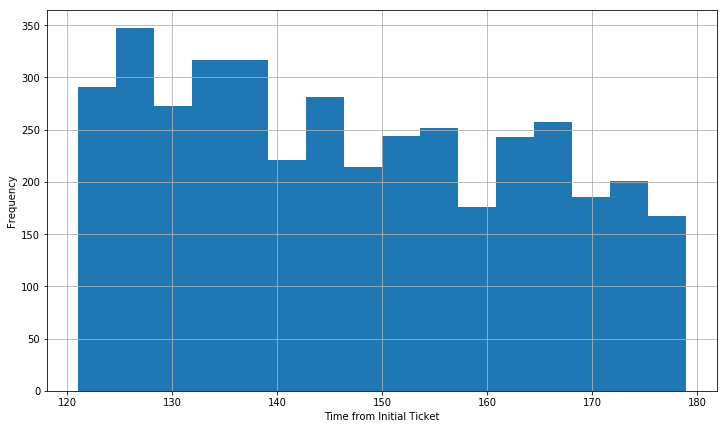

In [66]:
df = df[(df.delta > 120) & (df.delta < 180)]
df['delta'].hist(bins = 'auto')
plt.xlabel('Time from Initial Ticket')
plt.ylabel('Frequency')

W'ell turn this into a cumulative distribution. 

/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


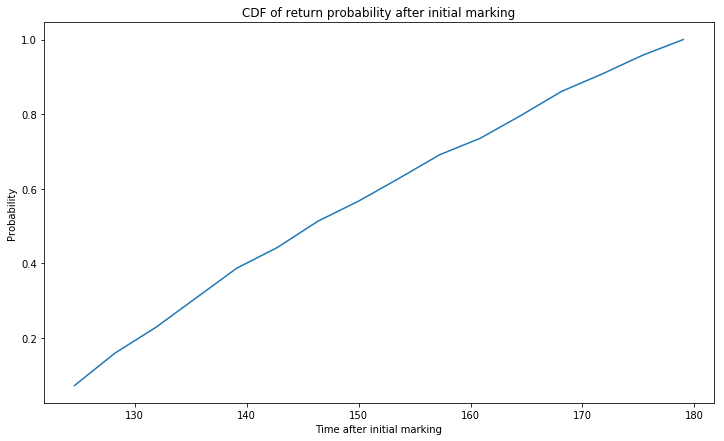

In [67]:
counts, bin_edges = np.histogram(df['delta'], bins = 'auto', normed = True)

cdf = np.cumsum(counts)
plt.plot(bin_edges[1:], cdf/cdf[-1])
plt.xlabel('Time after initial marking')
plt.ylabel('Probability')
plt.title('CDF of return probability after initial marking')
plt.show()

Now we combine this with our original probability of rate. Because these probabilities are sepaarate dimensions,we will have to use simulated data to create one probability distribution. 

In [68]:
#Add initial arrival time
x = np.random.random(size = 1000)

def f(x, arrival_rate):
    return -math.log(1.0 - x) / (1/arrival_rate)

firstpass = [f(x, arrival_rate) for x in x]
#firstpass = firstpass.rvs(size = 1000)
#Create discrete random variable from 2nd arrival rate distribution
values = df['delta']
probs = 1/ df['delta'].shape[0]
combination = pd.DataFrame({'val': values, 'probs' : probs})
df = combination.groupby(by = 'val', as_index = False)['probs'].sum()
custom = stats.rv_discrete(values = (df['val'], df['probs']))
secondpass = custom.rvs(size = 1000)

totalprob =  firstpass + secondpass


/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


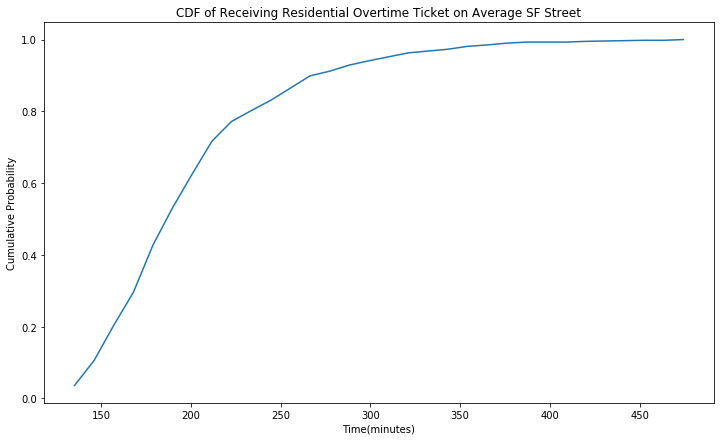

In [69]:
counts, bin_edges = np.histogram(totalprob, bins = 'auto', normed = True)
cdf = np.cumsum(counts)
plt.plot(bin_edges[1:], cdf/cdf[-1])
plt.title('CDF of Receiving Residential Overtime Ticket on Average SF Street')
plt.ylabel("Cumulative Probability")
plt.xlabel("Time(minutes)")
plt.show()

However, this study was based around the variability of arrival rates by streets, so lets use the arrival rates from our least and most patrolled streets, categorized from our regression model. 

We know that we can identify streets he is less likely to travel down, so lets compare some different probability plots. That of the highest category, that of the overall average, and that of the worst category. We'll also try to include some confidence intervals. 

/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  after removing the cwd from sys.path.
/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  after removing the cwd from sys.path.
/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: VisibleD

Text(0.5, 1.0, 'Probability of receiveing a ticket, split by OLS fitted volume populations')

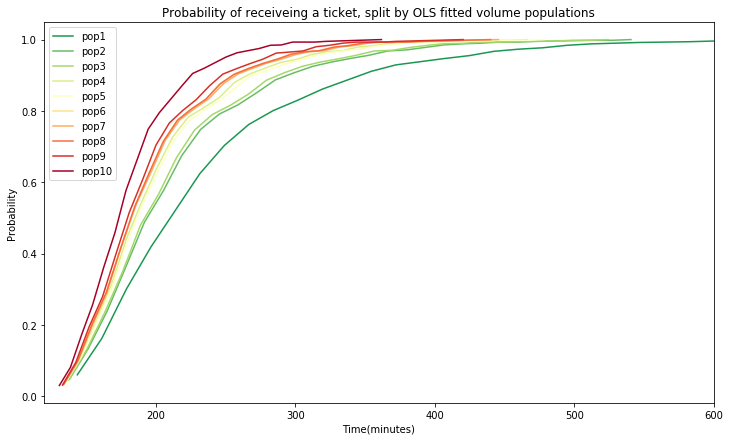

In [70]:
def plot_mean(mean, title, color):
    firstpass_mean = [f(x, mean) for x in x]
    totalprob_mean =  firstpass_mean + secondpass
    counts_mean, bin_edges_mean = np.histogram(totalprob_mean, bins = 'auto', normed = True)
    cdf_mean = np.cumsum(counts_mean)    
    plt.plot(bin_edges_mean[1:], cdf_mean/cdf_mean[-1], color =color, label = title)
    
for i in range(1,11):
    mean= arrival_rate * means['base'] / means[i]
    title = 'pop' + str(i)
    color = plt.cm.RdYlGn(1-i/10)
    plot_mean(mean, title, color)

plt.legend()
plt.xlabel('Time(minutes)')
plt.ylabel('Probability')
plt.xlim(120,600)
plt.title('Probability of receiveing a ticket, split by OLS fitted volume populations')


/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been 

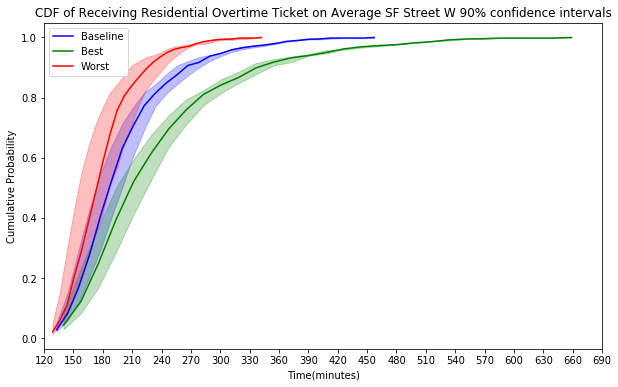

In [74]:
plt.figure(figsize = (10,6))
arrival = arrival_rate
arrival_lci = arrival_rate *   means['base'] / (means['base'] + 1.64*stds['base'])
arrival_uci = arrival_rate *  means['base'] / (means['base'] - 1.64*stds['base'])
   
arrival_best = arrival_rate * means['base'] / means[1]
arrival_best_lci = arrival_rate * means['base'] / (means[1] - 1.64*stds[1])
arrival_best_uci = arrival_rate * means['base'] / (means[1] + 1.64*stds[1])

arrival_worst = arrival_rate * means['base'] / means[10]
arrival_worst_lci = arrival_rate * means['base'] / (means[10] - 1.64*stds[10])
arrival_worst_uci = arrival_rate * means['base'] / (means[10] + 1.64*stds[10])

x = np.random.random(size = 1000)

def f(x, arrival):
    return -math.log(1.0 - x) / (1/arrival)


def plot_mean_ci(mean, lci, uci, title, color):
    firstpass_lci = [f(x, lci) for x in x]
    firstpass_mean = [f(x, mean) for x in x]
    firstpass_uci = [f(x, uci) for x in x]
    
    totalprob_lci =  firstpass_lci + secondpass
    totalprob_mean =  firstpass_mean + secondpass
    totalprob_uci =  firstpass_uci + secondpass

    
    counts_mean, bin_edges_mean = np.histogram(totalprob_mean, bins = 30, normed = True)
    cdf_mean = np.cumsum(counts_mean)
    
    counts_low, bin_edges_low = np.histogram(totalprob_lci, bins = 30, normed = True)
    cdf_low = np.cumsum(counts_low)

    counts_high, bin_edges_high = np.histogram(totalprob_uci, bins = 30, normed = True)
    cdf_high = np.cumsum(counts_high)
    
    
   
    x_ = bin_edges_mean[1:]
    plt.plot(bin_edges_mean[1:], cdf_mean/cdf_mean[-1], color = color, label = title)
    #plt.fill_between(range(bin_edges_mean.min, bin_edges_mean.max), cdf_low, cdf_high, color = color, alpha = .25)
    plt.fill_between(x_,cdf_low/cdf_low[-1], cdf_high/cdf_high[-1], color = color, alpha = .25)


plot_mean_ci(arrival, arrival_lci, arrival_uci, 'Baseline', 'blue')
plot_mean_ci(arrival_best, arrival_best_lci, arrival_best_uci, 'Best', 'green')
plot_mean_ci(arrival_worst, arrival_worst_lci, arrival_worst_uci, 'Worst', 'red')
plt.title('CDF of Receiving Residential Overtime Ticket on Average SF Street W 90% confidence intervals')
plt.ylabel("Cumulative Probability")
plt.xlabel("Time(minutes)")
plt.legend()
plt.xlim(120,480)
plt.xticks(np.arange(120,720,30))
plt.show()


# Theory
Although more street cleaning tickets are given out at 8 AM, 12 PM is more effective per linear foot because it is in the middle of the day and people(myself) would forget. Also, less consistency (once a week, every other week, etc) increases the effectiveness of getting tickets (per street clean). 2 AM is least effective because no one dares try to wake up beforehand. 
We'll use the street cleaning ID on this one to look at what links get the most street cleaning tickets. 

In [75]:
sweep = result_query('Select t1.lineid, fromhour, tohour, weekday, totalpermonth,  distance, nhood, park_supply from street_sweep_data t1 '
                  'join street_volume_data t2 on t1.lineid = t2.lineid')
ticks = result_query("Select TicketNumber, TickIssueDate, TickIssueTime, lineid from ticket_data t1 join address_data t2 "
                     " on t1.address = t2.address where ViolationDesc = 'STR CLEAN'")
weekdaydict = {0: 'Mon', 1:'Tues', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}

ticks['weekday'] = ticks['TickIssueDate'].apply(lambda x: weekdaydict[pd.to_datetime(x).weekday()])

sweep.drop_duplicates(subset = ['lineid', 'weekday'], inplace = True)

In [76]:
byclean = ticks.groupby(by = ['lineid', 'weekday'], as_index = False)['TicketNumber'].agg('count')

In [77]:
ticks = byclean.merge(sweep, left_on = ['lineid', 'weekday'], right_on = ['lineid', 'weekday'])
ticks.dropna(subset= ['park_supply'], inplace = True)
ticks = ticks[ticks.park_supply > 0]
ticks['TicketNumber'] = ticks['TicketNumber'] / totalyears

In [78]:
ticks['miles_sweeped_year'] = ticks['totalpermonth'] * 12 * ticks['distance']

In [79]:
#Success rate is basically tickets per mile swept
ticks['success_rate'] = ticks['TicketNumber'] / ticks['miles_sweeped_year'] 

In [80]:
ticks.sort_values(by = 'success_rate', ascending = False)[:10]

,lineid,weekday,TicketNumber,fromhour,tohour,totalpermonth,distance,nhood,park_supply,miles_sweeped_year,success_rate
7909,40405.0,Mon,177.433667,06:00,08:00,5,0.01000,Inner Mission,2.0,0.60000,295.722779
13544,48376.0,Wed,135.955667,12:00,14:00,2,0.02000,Inner Sunset,11.0,0.48000,283.240973
16745,53311.0,Fri,33.182400,10:00,12:00,2,0.00549,Marina,2.0,0.13176,251.839709
15159,50652.0,Thu,114.294934,09:00,11:00,2,0.02000,Lake,6.0,0.48000,238.114445
1993,31027.0,Fri,127.660067,08:00,10:00,2,0.02730,Bernal Heights North,7.0,0.65520,194.841372
17253,55788.0,Mon,86.642934,09:00,11:00,2,0.02000,Sea Cliff,6.0,0.48000,180.506112
1994,31027.0,Tues,101.851534,08:00,10:00,2,0.02730,Bernal Heights North,7.0,0.65520,155.451059
15176,50675.0,Mon,181.581467,09:00,11:00,2,0.05000,Lake,20.0,1.20000,151.317889
7910,40405.0,Thu,84.799467,06:00,08:00,5,0.01000,Inner Mission,2.0,0.60000,141.332445
12636,46959.0,Wed,191.720534,11:00,13:00,2,0.06000,Pacific Heights,21.0,1.44000,133.139260


It looks as if our theory is holding up, with the highest success rates being those that are swept once per month. 

In [92]:
ti = result_query('Select * from street_sweep_data where lineid = 49875')

In [91]:
ticks[ticks.totalpermonth == 6]

,lineid,weekday,TicketNumber,fromhour,tohour,totalpermonth,distance,nhood,park_supply,miles_sweeped_year,success_rate
14667,49875.0,Wed,153.468600,08:00,10:00,6,0.06,Central Sunset,20.0,4.32,35.525139
15429,51009.0,Wed,2.304333,08:00,10:00,6,0.06,Central Sunset,6.0,4.32,0.533410
15435,51020.0,Wed,4.608667,08:00,10:00,6,0.06,Central Sunset,6.0,4.32,1.066821
15668,51307.0,Wed,5.069533,08:00,10:00,6,0.06,Outer Sunset,25.0,4.32,1.173503
15672,51312.0,Wed,4.147800,08:00,10:00,6,0.06,Outer Sunset,16.0,4.32,0.960139
15713,51377.0,Wed,17.052067,08:00,10:00,6,0.06,Outer Sunset,16.0,4.32,3.947238
16133,51983.0,Wed,15.669467,08:00,10:00,6,0.06,Outer Sunset,16.0,4.32,3.627191
16136,51988.0,Wed,25.347667,08:00,10:00,6,0.06,Outer Sunset,15.0,4.32,5.867515
16140,51995.0,Wed,8.756467,08:00,10:00,6,0.06,Outer Sunset,14.0,4.32,2.026960


In [93]:
ti

,index,blockside,blocksweep,cnn,cnnrightle,corridor,district,fromhour,holidays,lf_fadd,...,tohour,total_ea,totalpermonth,week1ofmon,week2ofmon,week3ofmon,week4ofmon,week5ofmon,weekday,zip_code
0,16716,South,1616994,8366101,L,Lincoln Way,None,09:00,N,2701,...,11:00,429.66747,2,1,0,1,0,0,Tues,94122
1,16717,North,1598109,8366201,R,Lincoln Way,None,08:00,N,0,...,10:00,429.66747,6,1,2,1,2,0,Wed,94122
2,16718,North,1598140,8366201,R,Lincoln Way,None,08:00,N,0,...,10:00,429.66747,6,1,2,1,2,0,Wed,94122
3,16719,North,1641969,8366201,R,Lincoln Way,None,08:00,N,0,...,10:00,429.66747,6,1,2,1,2,0,Wed,94122
4,28247,South,1616994,8366101,L,Lincoln Way,None,09:00,N,2701,...,11:00,5.48971,2,1,0,1,0,0,Tues,94122
5,28248,South,1616994,8366101,L,Lincoln Way,None,09:00,N,2701,...,11:00,2.85005,2,1,0,1,0,0,Tues,94122
6,28249,North,1598109,8366201,R,Lincoln Way,None,08:00,N,0,...,10:00,5.48971,6,1,2,1,2,0,Wed,94122
7,28250,North,1598109,8366201,R,Lincoln Way,None,08:00,N,0,...,10:00,2.85005,6,1,2,1,2,0,Wed,94122
8,28251,North,1598140,8366201,R,Lincoln Way,None,08:00,N,0,...,10:00,5.48971,6,1,2,1,2,0,Wed,94122
9,28252,North,1598140,8366201,R,Lincoln Way,None,08:00,N,0,...,10:00,2.85005,6,1,2,1,2,0,Wed,94122


Text(0.5, 1.0, 'Average Tickets per Mile swept number of sweeps per month')

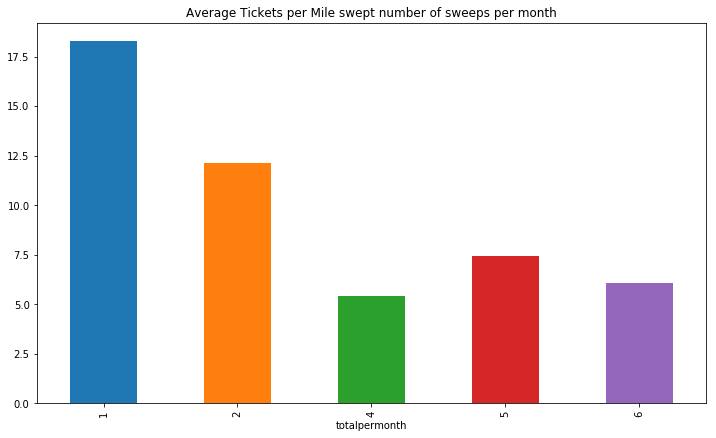

In [81]:
ticks.groupby(by = 'totalpermonth')['success_rate'].mean().plot(kind = 'bar')
plt.title('Average Tickets per Mile swept number of sweeps per month')

It appears out theory is true, proving that more inconsistently swept streets are more effective. Let's combine by StreetID so we can get streets that are MWF, etc. 

In [82]:
by_street = ticks.groupby('lineid')[['totalpermonth', 'distance', 'TicketNumber']].sum()

In [83]:
by_street['miles_sweeped_year'] = by_street['totalpermonth'] * 12 * by_street['distance']
by_street['success_rate'] = by_street['TicketNumber'] / by_street['miles_sweeped_year'] 

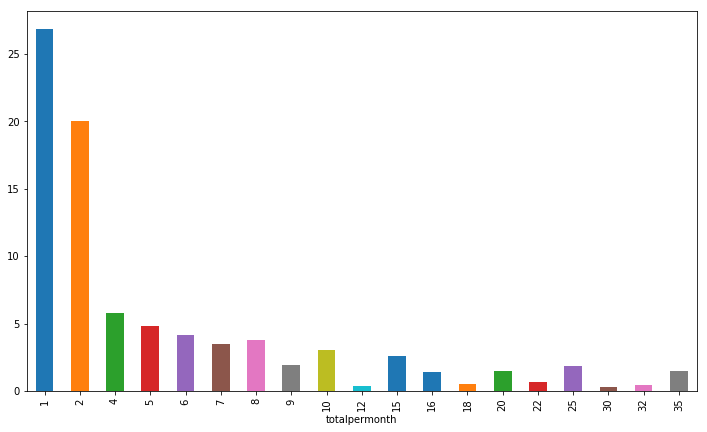

In [84]:
by_street.groupby('totalpermonth')['success_rate'].mean().plot(kind = 'bar')

Some streets are every single day of the week, which would show up as 7X5 =35 days here. In reality thats not possible. 
However, our theory holds that less frequent street cleaning is much more effective at getting tickets per mile swept, assuming their goal isn't actually related to street cleanliness. 

Text(0.5, 1.0, 'Average Tickets per Mile Swept by Hour of Day Start')

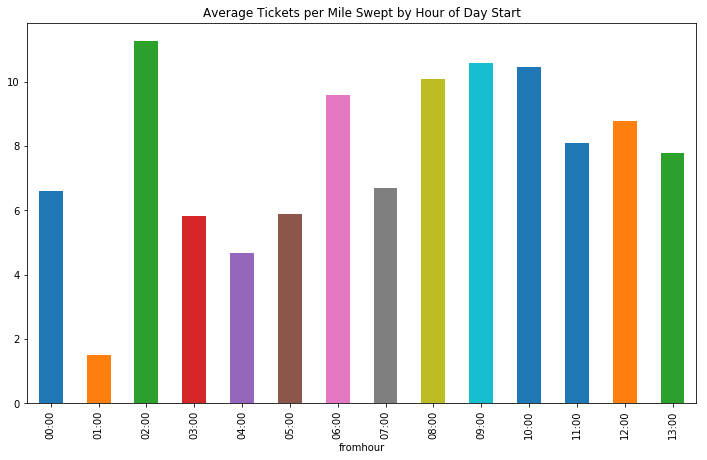

In [85]:
by_hour = ticks.groupby(by = 'fromhour')['success_rate'].mean().plot(kind = 'bar')
plt.title('Average Tickets per Mile Swept by Hour of Day Start')

In [86]:
The other theory is incorrect, morning sweeping is the most effective.

SyntaxError: invalid syntax (<ipython-input-86-e02d7184b88c>, line 1)

In [ ]:
plt.figure(figsize = (10,6))
daydict = {'Mon':1, 'Tues':2, 'Wed' :3, 'Thu': 4, 'Fri': 5, 'Sat': 6, 'Sun': 7}
df = ticks.groupby(by = 'weekday',as_index = False)['success_rate'].mean()
df['daynum'] = df['weekday'].map(daydict)
df.sort_values(by = 'daynum', inplace = True)
df.drop(columns = 'daynum', inplace = True)
plt.bar(x = df['weekday'],height = df['success_rate'])
plt.title('Average Tickets per Mile swept by Day of Week')

Weekends look to catch people off guard. 